# SPI script
Script to generate SPI for ACS GWLs

Chore list:
- update spi function in core functions
- add in monthly / daily functionality into function
- write spi_array as netcdf

In [1]:
import os
os.chdir('/g/data/mn51/users/jb6465/acs-drought/percentiles_spi_spei_smi')
import dictionaries
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from core_functions import mask_ocean, calculate_spi, load_target_variable
# from plot_write_functions import plot_write_percentile_threshold, plot_comparison_box_whisker, plot_comparison_heatmap

### DASK setup

In [2]:
import dask
import tempfile
from dask.diagnostics import ProgressBar
from dask.distributed import Client, LocalCluster

dask.config.set({
    'array.chunk-size': "256 MiB",
    'array.slicing.split_large_chunks': True, #This can make AXIOM very slow
    'distributed.comm.timeouts.connect': '120s',
    'distributed.comm.timeouts.tcp': '120s',
    'distributed.comm.retry.count': 10,
    'distributed.scheduler.allowed-failures': 20,
    "distributed.scheduler.worker-saturation": 1.1, #This should use the new behaviour which helps with memory pile up
})

# client = dask.distributed.Client()
client = Client(n_workers=10, threads_per_worker=1, local_directory = tempfile.mkdtemp(), memory_limit = "63000mb")
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 10
Total threads: 10,Total memory: 586.73 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37453,Workers: 10
Dashboard: /proxy/8787/status,Total threads: 10
Started: Just now,Total memory: 586.73 GiB
Comm: tcp://127.0.0.1:38063,Total threads: 1
Dashboard: /proxy/37079/status,Memory: 58.67 GiB
Nanny: tcp://127.0.0.1:42931,


In [17]:
# client.close()

### Load rainfall

In [3]:
BC_SWITCH = False
BC_METHOD = 'QME'
BC_SOURCE = 'AGCD' #AGCD BARRA-R2

In [4]:
rain = load_target_variable('var_p', 3, ['full'],\
                            bc=BC_SWITCH, bc_method=BC_METHOD, bc_source=BC_SOURCE)

---> BC SWITCH OFF: USING DATA FROM py18 AND hq89

---> LOADING FULL PERIOD
- AGCD
- BARPA-R-CMCC-ESM2 (r1i1p1f1)
- BARPA-R-ACCESS-ESM1-5 (r6i1p1f1)
- BARPA-R-ACCESS-CM2 (r4i1p1f1)
- BARPA-R-EC-Earth3 (r1i1p1f1)
- BARPA-R-CESM2 (r11i1p1f1)
- BARPA-R-MPI-ESM1-2-HR (r1i1p1f1)
- BARPA-R-NorESM2-MM (r1i1p1f1)
- CCAM-v2203-SN-CMCC-ESM2 (r1i1p1f1)
- CCAM-v2203-SN-ACCESS-ESM1-5 (r6i1p1f1)
- CCAM-v2203-SN-ACCESS-CM2 (r4i1p1f1)
- CCAM-v2203-SN-EC-Earth3 (r1i1p1f1)
- CCAM-v2203-SN-CESM2 (r11i1p1f1)
- CCAM-v2203-SN-CNRM-ESM2-1 (r1i1p1f2)


In [5]:
rain['full']['BARPA-R']['ACCESS-ESM1-5']

<xarray.DataArray 'pr' (time: 1680, lat: 436, lon: 777)> Size: 5GB
dask.array<getitem, shape=(1680, 436, 777), dtype=float64, chunksize=(1680, 221, 395), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 13kB 1961-01-16T12:00:00 ... 2100-12-16T12...
  * lat      (lat) float64 3kB -53.58 -53.42 -53.27 -53.11 ... 13.32 13.48 13.63
  * lon      (lon) float64 6kB 88.04 88.19 88.34 88.5 ... 207.6 207.8 207.9

In [6]:
import numpy as np
import xarray as xr
from scipy.stats import gamma, norm

fitting_method = 'MLE'
input_array = rain['full']['BARPA-R']['ACCESS-ESM1-5']

input_array = input_array.chunk({'time': -1, 'lat': 'auto', 'lon': 'auto'})


In [8]:
import numpy as np
import xarray as xr
from scipy.stats import gamma, norm

fitting_method = 'MLE'
input_array = rain['full']['BARPA-R']['ACCESS-ESM1-5']

def compute_spi(monthly_data, month):
    print(f"Processing month: {month}")  # Print the month being processed

    # Compute gamma distribution parameters using non-zero observations
    non_zero_base_period = monthly_data.where(monthly_data > 0).dropna(dim='time')

    alpha, loc, beta = xr.apply_ufunc(
        gamma.fit,
        non_zero_base_period,
        input_core_dims=[['time']],
        output_core_dims=[[], [], []],
        vectorize=True,
        dask='parallelized',
        dask_gufunc_kwargs={'allow_rechunk': True},
        output_dtypes=[float, float, float],
        kwargs={'floc': 0, 'method': fitting_method}
    )

    # Calculate the gamma cumulative distribution function (CDF)
    p_zero = np.sum(monthly_data.values == 0, axis=0) / monthly_data.values.shape[0]
    gamma_cdf = gamma.cdf(non_zero_base_period, alpha, scale=beta)
    cdf = p_zero + (1 - p_zero) * gamma_cdf

    # Apply inverse normal distribution
    norm_ppf = norm.ppf(cdf)

    return xr.DataArray(norm_ppf, coords=non_zero_base_period.coords, dims=non_zero_base_period.dims)

# Group by month and apply the SPI calculation
spi_array_grouped = input_array.groupby('time.month').map(lambda x: compute_spi(x, x['time.month'].values[0]))



Processing month: 1
Processing month: 2
Processing month: 3
Processing month: 4
Processing month: 5
Processing month: 6
Processing month: 7
Processing month: 8
Processing month: 9
Processing month: 10
Processing month: 11
Processing month: 12


In [11]:
spi_array = xr.full_like(input_array, fill_value=np.nan)

In [12]:
spi_array.loc[{'time': spi_array_grouped['time']}] = spi_array_grouped

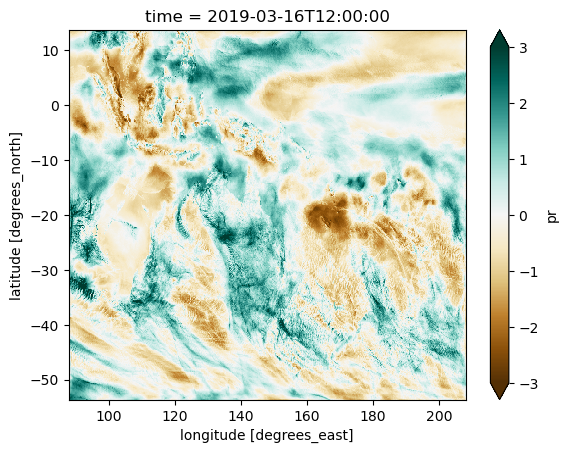

In [14]:
spi_array[698].plot(cmap='BrBG', vmin=-3, vmax=3)

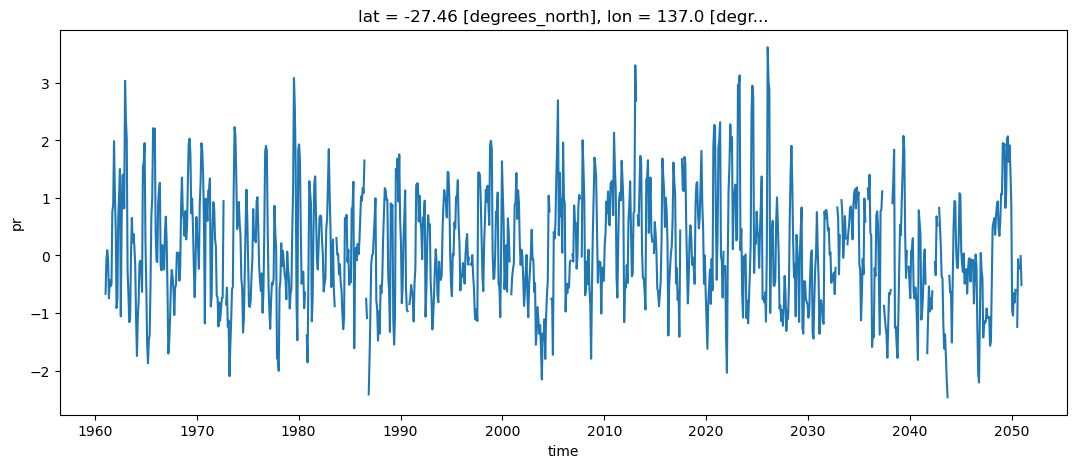

In [15]:
spi_ts = spi_array.sel(lat=-27.5,lon=137,method='nearest')#mean(['lat','lon'])
spi_ts.sel(time=slice('1960','2050')).plot(figsize=(13,5))